In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import torch
from transformers import EarlyStoppingCallback

# Load the dataset
df = pd.read_csv("bbc_text_cls.csv")

# Ensure column names are consistent
df.columns = df.columns.str.strip().str.lower()

# Verify the column names
if 'text' not in df.columns or 'labels' not in df.columns:
    raise ValueError("The dataset must contain 'text' and 'labels' columns.")

# Step 1: Split into training and test sets (80-20 split) - test set is set aside for final evaluation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Step 2: Further split train_data into training and validation sets (80-20 split of training data)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['labels'])

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Map label names to integers
label_mapping = {label: idx for idx, label in enumerate(df['labels'].unique())}
train_dataset = train_dataset.map(lambda x: {'labels': label_mapping[x['labels']]})
val_dataset = val_dataset.map(lambda x: {'labels': label_mapping[x['labels']]})
test_dataset = test_dataset.map(lambda x: {'labels': label_mapping[x['labels']]})

# Load the ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Preprocess the text data
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Tokenize the datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Set the format for PyTorch tensors
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Load ALBERT model for sequence classification
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(label_mapping))

# Freeze all layers except the classification head
for param in model.albert.parameters():
    param.requires_grad = False

# Ensure the function is defined
def check_frozen_layers(model):
    frozen_layers = []
    trainable_layers = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_layers.append(name)
        else:
            frozen_layers.append(name)

    print("\nTrainable Layers (Unfrozen):")
    for layer in trainable_layers:
        print(f"- {layer}")

    print("\nFrozen Layers:")
    for layer in frozen_layers:
        print(f"- {layer}")

    # Confirmation message
    if all("classifier" in layer for layer in trainable_layers) and len(trainable_layers) == 2:
        print("\nConfirmation: Only the classification head is trainable!")
    else:
        print("\nWarning: Some unexpected layers are trainable!")

# Call this function to check frozen layers after model initialization
check_frozen_layers(model)


# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",              # Evaluate on the validation set after each epoch
    save_strategy="epoch",
    learning_rate=5e-4,                       # Higher learning rate since only the classification head is trainable
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,                      # Train for more epochs
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True               # Load the best model based on validation loss
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Adjust early stopping patience
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the validation set
val_results = trainer.evaluate()
print(f"Validation Results: {val_results}")

# Evaluate the model on the test set
test_predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(test_predictions.predictions), axis=1).numpy()
true_labels = test_predictions.label_ids

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the fine-tuned model
trainer.save_model("./fine_tuned_albert_bbc")


Map:   0%|          | 0/1424 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Map:   0%|          | 0/1424 [00:00<?, ? examples/s]

Map:   0%|          | 0/356 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Trainable Layers (Unfrozen):
- classifier.weight
- classifier.bias

Frozen Layers:
- albert.embeddings.word_embeddings.weight
- albert.embeddings.position_embeddings.weight
- albert.embeddings.token_type_embeddings.weight
- albert.embeddings.LayerNorm.weight
- albert.embeddings.LayerNorm.bias
- albert.encoder.embedding_hidden_mapping_in.weight
- albert.encoder.embedding_hidden_mapping_in.bias
- albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight
- albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias
- albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight
- albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias
- albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight
- albert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.bias
- albert.encoder.albert_layer_groups.0.albert_layers.0.attention.value.weight
- albert.encoder.albert_layer_groups.0.albert_layers.0.

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.540100,1.312427
2,1.264300,1.177279
3,1.122200,1.081533
4,1.016200,1.026681
5,1.031000,0.955037
6,0.951200,0.921532
7,0.912300,0.877709
8,0.862100,0.863705
9,0.817900,0.833133
10,0.791800,0.814544


Validation Results: {'eval_loss': 0.5934434533119202, 'eval_runtime': 0.6936, 'eval_samples_per_second': 513.286, 'eval_steps_per_second': 33.162, 'epoch': 50.0}
Test Accuracy: 81.80%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Assuming the labels are for categories: Business, Entertainment, Politics, Sport, Tech
label_names = ["Business", "Entertainment", "Politics", "Sport", "Tech"]

test_predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(test_predictions.predictions), axis=1).numpy()
true_labels = test_predictions.label_ids

# Print classification report with label names
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=label_names))



Classification Report:
                precision    recall  f1-score   support

     Business       0.77      0.77      0.77       102
Entertainment       0.81      0.83      0.82        77
     Politics       0.77      0.86      0.81        84
        Sport       0.95      0.90      0.92       102
         Tech       0.77      0.71      0.74        80

     accuracy                           0.82       445
    macro avg       0.82      0.82      0.81       445
 weighted avg       0.82      0.82      0.82       445



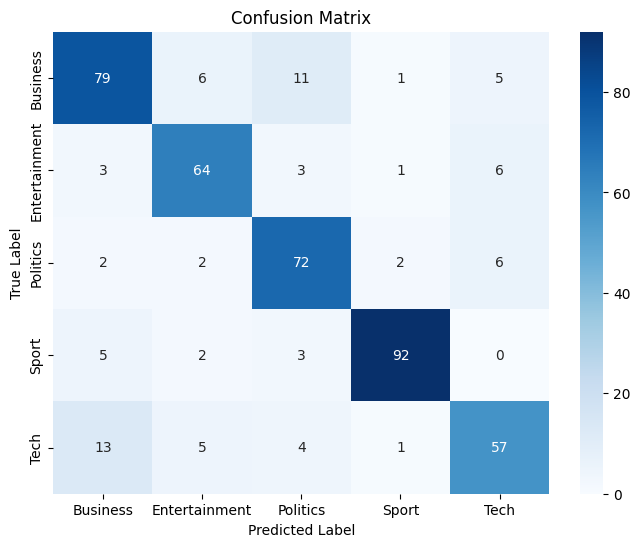

In [ ]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names based on your labels
class_names = ['Business', 'Entertainment', 'Politics', 'Sport', 'Tech']
plot_confusion_matrix(true_labels, predicted_labels, classes=class_names)


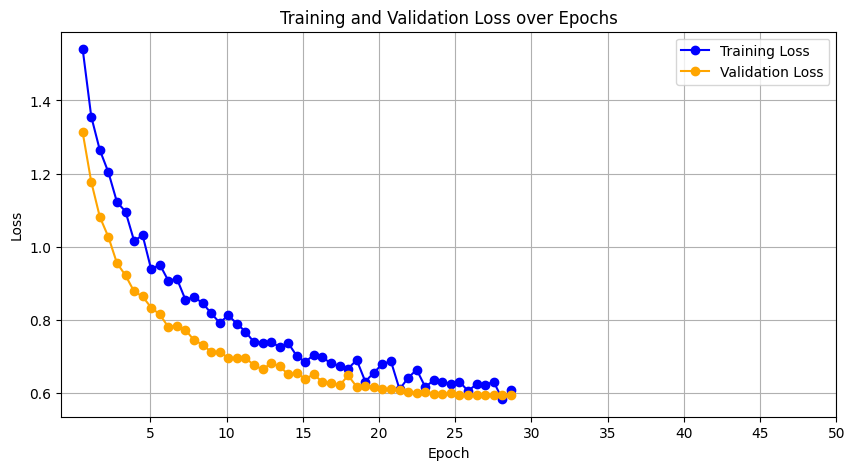

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store epoch-wise metrics
epochs = []
train_loss = []
val_loss = []

# Extract metrics from the trainer's log history
for log in trainer.state.log_history:
    if 'epoch' in log:
        current_epoch = log['epoch']
        if 'loss' in log:  # Training loss
            train_loss.append(log['loss'])
            epochs.append(current_epoch)
        if 'eval_loss' in log:  # Validation loss
            val_loss.append(log['eval_loss'])

# Align lengths by truncating to the shortest list length
min_len = min(len(epochs), len(train_loss), len(val_loss))
epochs = epochs[:min_len]
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]

# Plot Training and Validation Loss over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label="Training Loss", color='blue')
plt.plot(epochs, val_loss, marker='o', label="Validation Loss", color='orange')
plt.xticks(ticks=range(5, len(epochs) + 1,5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()
